In [1]:
import matplotlib.pyplot as plt

import numpy as np
import numexpr as ne
from numpy import convolve
from scipy.signal import fftconvolve

ne.set_num_threads(12)

from bootstrap import default

import use_cffi
import use_ctypes
import use_cython
import use_cusignal
import use_numba
#import use_pythran

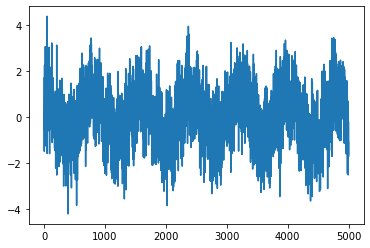

In [2]:
signal, references, window = default()

plt.plot(signal[0,:])

In [14]:
# Basic implementation using Numpy (+MKL?)
def numpy_go(signal, references, window):
    N, k = signal.shape
    M = references.shape[0]

    results = np.zeros((M, N))
    for i in range(M):
        buffer = references[i,:] * signal
        buffer = fftconvolve(buffer, np.tile(window, (N,1)), mode='same', axes=1) 
        results[i,:] = np.mean(buffer, axis=1)
    return results

def numpy_expr_go(signal, references, window):
    N, k = signal.shape
    M = references.shape[0]

    results = np.zeros((M, N))
    for i in range(M):
        refx = references[i,:]
        buffer = ne.evaluate('refx * signal')
        buffer = fftconvolve(buffer, np.tile(window, (N,1)), mode='same', axes=1) 
        results[i,:] = np.mean(buffer, axis=1)
    return results
    

Numpy (+MKL):
270 ms ± 690 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
Numpy + Numexpr
265 ms ± 1.76 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


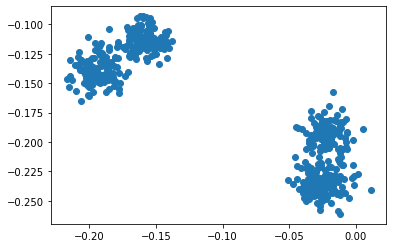

In [15]:
averages = numpy_go(signal, references, window)

plt.plot(*averages, 'o')

print("Numpy (+MKL):")
%timeit numpy_go(signal, references, window)

print("Numpy + Numexpr")
%timeit numpy_expr_go(signal, references, window)


CFFI:
50.7 ms ± 460 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


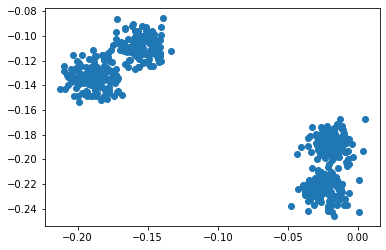

In [18]:
# Run demodulation using a CFFI implementation
averages = use_cffi.go(signal, references, window)
plt.plot(*averages, 'o')

print("CFFI:")
%timeit use_cffi.go(signal, references, window)

ctypes:
79.6 ms ± 234 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


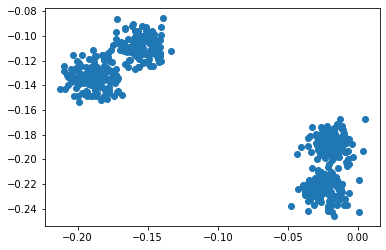

In [19]:
# Run demodulation using a ctypes implementation
averages = use_ctypes.go(signal, references, window)
plt.plot(*averages, 'o')

print("ctypes:")
%timeit use_ctypes.go(signal, references, window)

Cython (without MT):
32.4 ms ± 219 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Cython (with MT):
6.23 ms ± 97.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


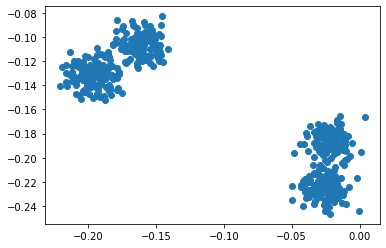

In [20]:
# Run demodulation using a cython implementation
averages = np.zeros((references.shape[0], signal.shape[0]))

use_cython.go(signal, references, window, averages=averages)
use_cython.go_with_mt(signal, references, window, averages=averages)

plt.plot(*averages, 'o')

print("Cython (without MT):")
%timeit use_cython.go(signal, references, window, averages=averages)

print("Cython (with MT):")
%timeit use_cython.go_with_mt(signal, references, window, averages=averages)

cuSignal (+CuPy):
49.4 ms ± 307 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


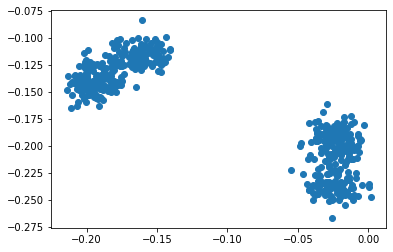

In [4]:
# Run demodulation using a cusignal implementation
gpuR, gpuW = use_cusignal.init_gpu(references, window)

averages = use_cusignal.go(signal, gpuR, gpuW)
plt.plot(*averages, 'o')

print("cuSignal (+CuPy):")
%timeit use_cusignal.go(signal, gpuR, gpuW)

cuSignal (+CuPy):
75.3 ms ± 514 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


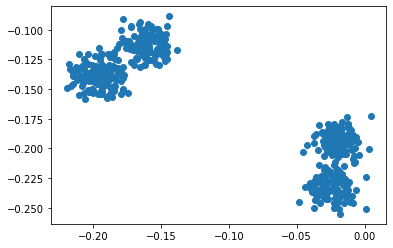

In [22]:
# Run demodulation using a cusignal implementation
gpuR, gpuW = use_cusignal.init_gpu(references, window)

averages = use_cusignal.go_cupy(signal, gpuR, gpuW)
plt.plot(*averages, 'o')

print("cuSignal (+CuPy):")
%timeit use_cusignal.go_cupy(signal, gpuR, gpuW)

Numba CPU:
1.59 s ± 14.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


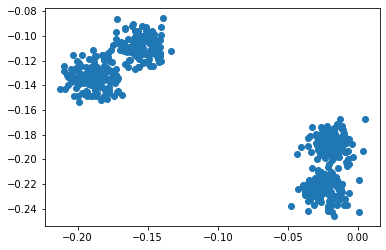

In [23]:
# Run demodulation using a Numba CPU implementation
averages = use_numba.go_cpu_mt(signal, references, window)
plt.plot(*averages, 'o')

print("Numba CPU:")
%timeit use_numba.go_cpu_mt(signal, references, window)

Numba GPU:
240 ms ± 609 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


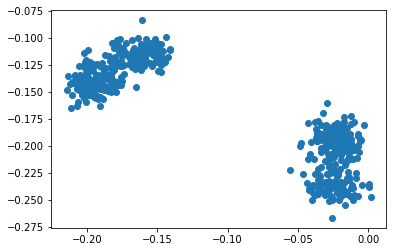

In [3]:
# Run demodulation using a Numba GPU implementation
gpuR, gpuW = use_numba.init_gpu(references, window)

averages = use_numba.go_cuda(signal, gpuR, gpuW)
plt.plot(*averages, 'o')

print("Numba GPU:")
%timeit use_numba.go_cuda(signal, gpuR, gpuW)